# Imports

In [5]:
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import great_expectations as ge
import pandas as pd
import seaborn as sns

# Exploratory Data Analysis

In [6]:
df_ratings = pd.read_csv(".\\data\\ratings.csv")#.drop(columns=["timestamp"])
print(df_ratings.shape)
print(df_ratings.info())
df_ratings.head()

(100836, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
df_movies = pd.read_csv(".\\data\\movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_tags = pd.read_csv(".\\data\\tags.csv")#.tag.str.lower().value_counts(dropna=False).sort_values(ascending=False)
# df_tags.drop(columns=["timestamp"], inplace=True)
df_tags.sample(3)

,userId,movieId,tag,timestamp
464,125,60950,threesome,1474591817
2513,477,593,suspense,1241396389
3282,567,161634,intense,1525287241


In [9]:
n_ratings = len(df_ratings)
n_movies = df_ratings['movieId'].nunique()
n_users = df_ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


C:\Users\Pedro Alves\AppData\Local\Temp\ipykernel_9112\842607662.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df_ratings, palette="viridis")


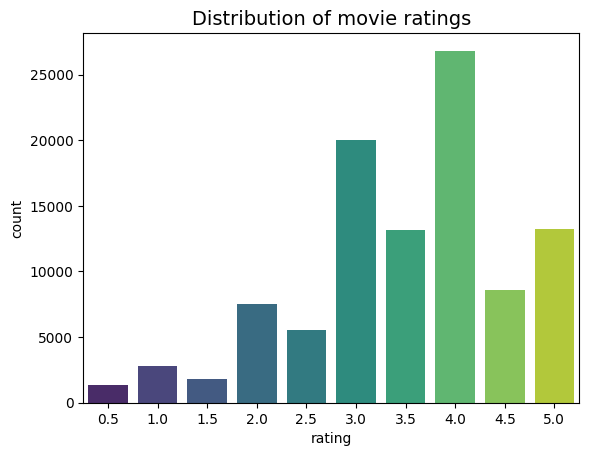

In [10]:
sns.countplot(x="rating", data=df_ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [11]:
print(f"Mean global rating: {round(df_ratings['rating'].mean(),2)}.")
mean_ratings = df_ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [12]:
movie_ratings = df_ratings.merge(df_movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

In [13]:
mean_ratings = df_ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
df_movies[df_movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [14]:
highest_rated = mean_ratings['rating'].idxmax()
df_movies[df_movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [15]:
df_ratings[df_ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [16]:
# Bayesian Average to take into consideration number of ratings
# Movies with small number of ratings but high ratings skew the dataset
movie_stats = df_ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [17]:
bayesian_avg_ratings = df_ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [18]:
movie_stats = movie_stats.merge(df_movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [19]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [20]:
# Check NaN's
df_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

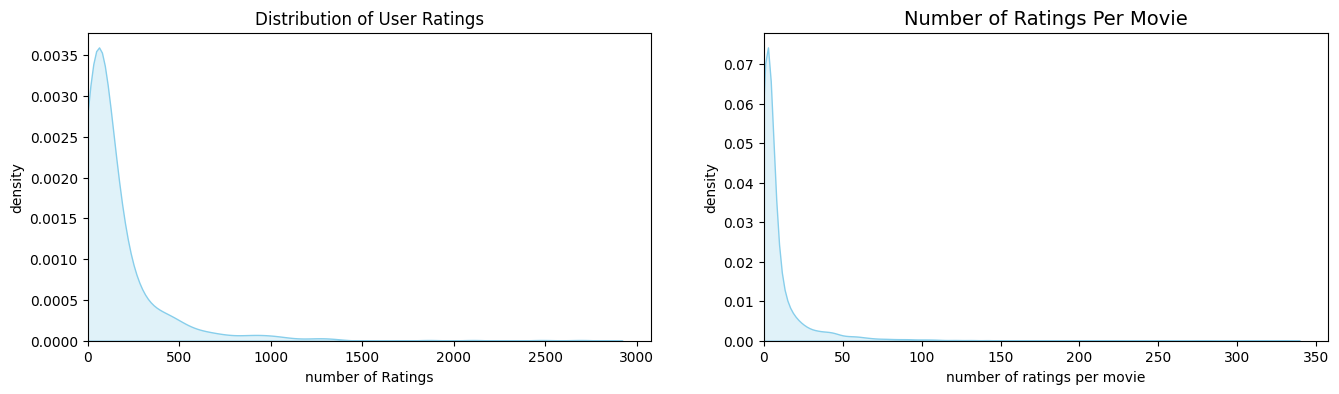

In [21]:
df_plot = df_ratings.groupby(["userId"]).agg(num_ratings=("rating", "count")).reset_index()
df_plot["userId"] = df_plot["userId"].astype(str)

df_plot2 = df_ratings.merge(df_movies, on='movieId').groupby(["movieId"]).agg(num_ratings=("rating", "count")).reset_index()
df_plot2["movieId"] = df_plot2["movieId"].astype(str)


plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(df_plot['num_ratings'], fill=True, color="skyblue")
plt.xlim(0)
plt.title('Distribution of User Ratings')
plt.xlabel('number of Ratings')
plt.ylabel('density')

plt.subplot(1,2,2)
sns.kdeplot(df_plot2['num_ratings'], fill=True, color="skyblue")
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [22]:
# distribution of ratings per user
df_plot = df_ratings.groupby(["userId"]).agg(num_ratings=("rating", "count")).reset_index().sort_values(by="num_ratings", ascending=False).head(20)
df_plot["userId"] = df_plot["userId"].astype(str)
fig = px.bar(df_plot, x='userId', y='num_ratings', text_auto=True)
fig.show()

c:\Users\Pedro Alves\Documents\GitHub\movie_recommender_system\myenv\lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [23]:
df_ratings[df_ratings.userId==53].merge(df_movies, on="movieId")

,userId,movieId,rating,timestamp,title,genres
0,53,203,5.0,1237748081,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
1,53,249,5.0,1237748109,Immortal Beloved (1994),Drama|Romance
2,53,381,5.0,1237748115,When a Man Loves a Woman (1994),Drama|Romance
3,53,413,5.0,1237748065,Airheads (1994),Comedy
4,53,481,5.0,1237748105,Kalifornia (1993),Drama|Thriller
5,53,748,5.0,1237748062,"Arrival, The (1996)",Action|Sci-Fi|Thriller
6,53,880,5.0,1237748077,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller
7,53,916,5.0,1237748102,Roman Holiday (1953),Comedy|Drama|Romance
8,53,922,5.0,1237748084,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
9,53,1049,5.0,1237748112,"Ghost and the Darkness, The (1996)",Action|Adventure


In [24]:
# distribution of ratings per movie
df_plot = df_ratings.groupby(["movieId"]).agg(num_ratings=("rating", "count")).reset_index().sort_values(by="num_ratings", ascending=False).head(20)
df_plot["movieId"] = df_plot["movieId"].astype(str)
fig = px.bar(df_plot, x='movieId', y='num_ratings', text_auto=True)
fig.show()

c:\Users\Pedro Alves\Documents\GitHub\movie_recommender_system\myenv\lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [25]:
df_movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [36]:
df_movies["year"] = df_movies.title.str[-6:].str.replace('(', '', regex=False).str.replace(')', '', regex=False)
df_movies["title"] = df_movies["title"].str[:-6]
df_movies = df_movies[df_movies["year"].str.isdigit()]
df_movies["year"] = df_movies["year"].astype(int)
df_movies["genres"] = df_movies["genres"].str.replace("|", ", ", regex=False)
df_movies.sample(5)

,movieId,title,genres,year
4961,7561,Paperhouse,"Fantasy, Horror, Thriller",1988
2850,3812,Everything You Always Wanted to Know About Sex...,Comedy,1972
5304,8796,"Funny Thing Happened on the Way to the Forum, A","Comedy, Musical",1966
1720,2312,Children of a Lesser God,Drama,1986
2996,4011,Snatch,"Comedy, Crime, Thriller",2000


In [ ]:
all_genres = df_movies["genres"].str.split(", ").explode()
all_genres = all_genres.value_counts(dropna=False).to_frame()
all_genres.reset_index(inplace=True)
all_genres.columns = ['genres', 'count']
fig = px.bar(all_genres, x='genres', y='count', text_auto=True)
fig.show()

In [ ]:
fig = px.histogram(df_movies, x="year")
fig.show()

In [27]:
df_tags = pd.read_csv(".\\data\\tags.csv")#.tag.str.lower().value_counts(dropna=False).sort_values(ascending=False)
# df_tags.drop(columns=["timestamp"], inplace=True)
df_tags.sample(3)

,userId,movieId,tag,timestamp
1070,474,282,twins,1137375594
1798,474,3456,In Netflix queue,1137201463
571,305,4995,mathematics,1464428783


In [28]:
df_tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [29]:
# Aggregates tags per user-movie pair in a row
df_tags = (
    df_tags.groupby(["userId", "movieId"])["tag"]
    .apply(", ".join)
    .reset_index()
    .rename(columns={"tag": "user_movie_tags"})
    .assign(user_movie_tags=lambda x: x["user_movie_tags"].str.lower())
)
# df_tags["user_movie_tags"] = df_tags["user_movie_tags"].str.lower()
df_tags.sample(5)

,userId,movieId,user_movie_tags
121,184,2579,"black and white, christopher nolan, directoria..."
1615,537,80906,"business, corruption, economics, investor corr..."
316,474,52,"adoption, prostitution"
104,125,42632,brutality
977,474,3548,1920s


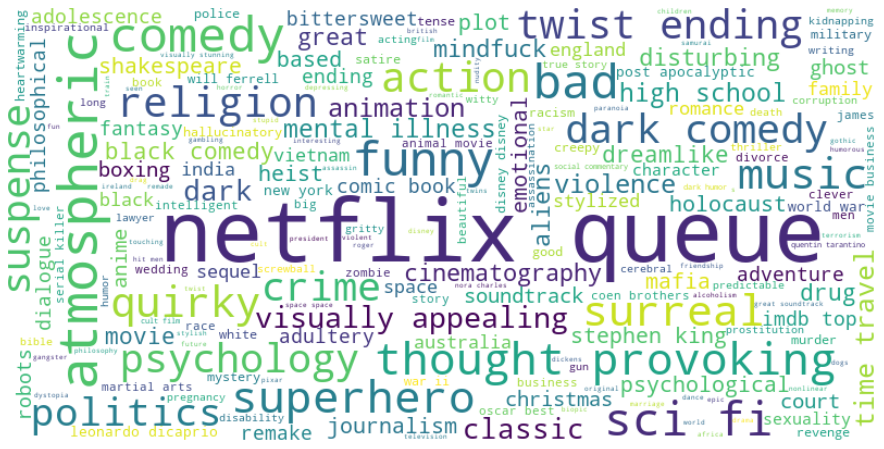

In [67]:
all_tags = df_tags["user_movie_tags"].str.split("|").explode()
tag_text = " ".join(all_tags)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(tag_text)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [68]:
# opted not to use this dataset because IMDB API is not free and TMDB API is not free for commercial use
pd.read_csv(".\\data\\links.csv").sample(2)

,movieId,imdbId,tmdbId
7862,93982,1486192,70436.0
4295,6279,281820,6016.0


# Join Data

In [69]:
df_ratings_tags = (
    df_ratings.drop(columns="timestamp")
    .merge(
        df_tags, 
        on=["userId", "movieId"], 
        how="left"
    )
)
df_ratings_tags.sample(5)

,userId,movieId,rating,user_movie_tags
23013,156,3506,4.0,NaN
30633,215,608,3.5,NaN
95239,600,912,2.5,NaN
98148,606,6373,2.5,NaN
70693,452,1258,4.0,NaN


In [70]:
df_ratings_tags.isna().sum()

userId                 0
movieId                0
rating                 0
user_movie_tags    99201
dtype: int64

In [87]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from typing import Dict, Any, Optional, Union, Callable, List

def handle_missing_values(
    df: pd.DataFrame, 
    column_rules: Optional[Dict[str, Any]] = None, 
    fill_numeric: float = None, 
    fill_categorical: str = None, 
    nan_threshold: float = 30,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Handle missing values in a DataFrame with column-specific rules.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to process
    column_rules : dict, optional
        Dictionary with column names as keys and specific fill values or methods as values.
        Methods can be 'median', 'mean', 'mode', or any specific value.
        Can also be a function that takes a Series and returns a value.
        Example: {'rating': 'median', 'tags': 'mode', 'category': 'Unknown', 'views': lambda x: x.max() * 0.5}
    fill_numeric : float | int, optional
        Default fill value for numeric columns not in column_rules
    fill_categorical : str | List[str], optional
        Default fill value for categorical columns not in column_rules
    nan_threshold : float, optional
        Only process columns with NaN percentage above this threshold
    verbose : bool, optional
        Whether to print information about the filling process
        
    Returns:
    --------
    pandas DataFrame
        The DataFrame with missing values handled
    """
    # Create a copy to avoid modifying the original DataFrame
    df_processed = df.copy()
    
    # Calculate NaN percentages
    nan_percentage = df_processed.isna().mean() * 100
    nan_columns = nan_percentage[nan_percentage > 0]
    
    if verbose and not nan_columns.empty:
        print("Columns with NaN values and their percentages:")
        print(nan_columns.to_string())
    
    # If no column rules provided, initialize empty dict
    if column_rules is None:
        column_rules = {}
    
    # Define strategy functions for common methods
    strategies = {
        'median': lambda series: series.median(),
        'mean': lambda series: series.mean(),
        'mode': lambda series: series.mode()[0] if not series.mode().empty else None,
        'most_common': lambda series: series.mode()[0] if not series.mode().empty else None,
        'min': lambda series: series.min(),
        'max': lambda series: series.max(),
        'zero': lambda series: 0,
    }
    
    # Process columns based on NaN percentage
    for col, percent in nan_percentage.items():
        if percent < nan_threshold:
            print(f"Dropping NaN subset in column: {col} (NaN {percent:.3f}%) because of NaN threshold {nan_threshold}")
            df_processed.dropna(subset=[col], inplace=True)
            break
        
        # Skip columns that don't exist in the DataFrame
        if col not in df_processed.columns:
            continue
        
        # Get the column data for convenience
        col_data = df_processed[col]
        is_numeric = is_numeric_dtype(col_data)
        is_categorical = is_categorical_dtype(col_data) or col_data.dtype == 'object'
        
        # Determine the fill value
        fill_value = None
        
        # Check if column has specific rule
        if col in column_rules:
            rule = column_rules[col]
            
            # Rule is a string strategy
            if isinstance(rule, str) and rule.lower() in strategies:
                strategy = strategies[rule.lower()]
                # Check if strategy is applicable (e.g., mean/median for numeric only)
                if (rule.lower() in ['mean', 'median'] and not is_numeric):
                    print(f"Warning: Cannot apply {rule} to non-numeric column {col}. Using mode instead.")
                    fill_value = strategies['mode'](col_data)
                else:
                    fill_value = strategy(col_data)
                
            # Rule is a function
            elif callable(rule):
                try:
                    fill_value = rule(col_data)
                except Exception as e:
                    print(f"Error applying custom function to {col}: {e}")
                    # Fall back to default
                    fill_value = fill_numeric if is_numeric else fill_categorical
                    
            # Rule is a direct value
            else:
                fill_value = rule
        
        # Apply default handling based on column type if no rule or rule processing failed
        if fill_value is None:
            if is_numeric:
                if fill_numeric is None:
                    fill_value = col_data.median()
                else:
                    fill_value = fill_numeric
            elif is_categorical:
                if fill_categorical is None and not col_data.mode().empty:
                    fill_value = col_data.mode()[0]
                else:
                    fill_value = fill_categorical
        
        # Apply the fill value
        print(f"Filling NaN in column: {col} (NaN {percent:.3f}%) with {fill_value}")
        
        df_processed[col].fillna(value=fill_value, inplace=True)
    
    return df_processed

# Example usage:
if __name__ == "__main__":
    # Sample DataFrame
    df = pd.DataFrame({
        'rating': [4.5, 3.2, None, 4.8, None],
        'tags': ['action', None, 'comedy', None, 'drama'],
        'category': ['movie', 'movie', 'movie', 'series', None],
        'views': [1000, 500, 100, 1500, 200]
    })
    
    # Define column-specific rules
    column_rules = {
        'rating': 'median',                 # Use median for ratings
        'tags': 'Missing tag',              # Use specific value for tags
        'category': 'Unknown',              # Use specific value for category
        'views': lambda x: x.mean() * 0.8   # Use custom function (80% of mean)
    }
    
    # Process the DataFrame
    df_processed = handle_missing_values(
        df, 
        column_rules=column_rules,
        fill_numeric=0,                     # Default for numeric columns not in rules
        fill_categorical="Not specified",   # Default for categorical columns not in rules
        nan_threshold=30,                    # Process all columns with any NaN values
        verbose=True                        # Print information about the process
    )
    
    print("\nOriginal DataFrame:")
    print(df)
    print("\nProcessed DataFrame:")
    print(df_processed)

Columns with NaN values and their percentages:
rating      40.0
tags        40.0
category    20.0
Filling NaN in column: rating (NaN 40.000%) with 4.5
Filling NaN in column: tags (NaN 40.000%) with Missing tag
Dropping NaN subset in column: category (NaN 20.000%) because of NaN threshold 30

Original DataFrame:
   rating    tags category  views
0     4.5  action    movie   1000
1     3.2    None    movie    500
2     NaN  comedy    movie    100
3     4.8    None   series   1500
4     NaN   drama     None    200

Processed DataFrame:
   rating         tags category  views
0     4.5       action    movie   1000
1     3.2  Missing tag    movie    500
2     4.5       comedy    movie    100
3     4.8  Missing tag   series   1500


In [300]:
df_ratings_tags.user_movie_tags.fillna(value="No tags", inplace=True)

In [77]:
df_preprocess = df_ratings_tags.merge(df_movies, on="movieId", how='left')

In [78]:
df_preprocess.isna().sum()

userId              0
movieId             0
rating              0
user_movie_tags     0
title              31
genres             31
year               31
dtype: int64

In [79]:
df_preprocess.shape

(100836, 7)

In [80]:
df_preprocess.isna().mean() * 100

userId             0.000000
movieId            0.000000
rating             0.000000
user_movie_tags    0.000000
title              0.030743
genres             0.030743
year               0.030743
dtype: float64

In [303]:
df_preprocess.dropna(subset=["title", "genres", "year"], inplace=True) # small proportion so it is safe to drop

In [304]:
df_preprocess.isna().sum()

userId             0
movieId            0
rating             0
user_movie_tags    0
title              0
genres             0
year               0
dtype: int64

In [305]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100805 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userId           100805 non-null  int64  
 1   movieId          100805 non-null  int64  
 2   rating           100805 non-null  float64
 3   user_movie_tags  100805 non-null  object 
 4   title            100805 non-null  object 
 5   genres           100805 non-null  object 
 6   year             100805 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 6.2+ MB


In [306]:
df_preprocess.head()

,userId,movieId,rating,user_movie_tags,title,genres,year
0,1,1,4.0,No tags,Toy Story,"Adventure, Animation, Children, Comedy, Fantasy",1995.0
1,1,3,4.0,No tags,Grumpier Old Men,"Comedy, Romance",1995.0
2,1,6,4.0,No tags,Heat,"Action, Crime, Thriller",1995.0
3,1,47,5.0,No tags,Seven (a.k.a. Se7en),"Mystery, Thriller",1995.0
4,1,50,5.0,No tags,"Usual Suspects, The","Crime, Mystery, Thriller",1995.0


# Data Quality

In [307]:
# Data quality checks with great expectations
ge_df = ge.from_pandas(df_preprocess)
ge_df.expect_column_values_to_not_be_null("userId")
ge_df.expect_column_values_to_not_be_null("movieId")
ge_df.expect_column_values_to_not_be_null("rating")
ge_df.expect_column_values_to_not_be_null("year")
ge_df.expect_column_values_to_not_be_null("title")
ge_df.expect_column_values_to_not_be_null("genres")
ge_df.expect_column_values_to_be_between("rating", min_value=0, max_value=5)
ge_df.expect_column_values_to_be_between("year", min_value=1900, max_value=2100)
ge_df.expect_column_values_to_not_be_null("title")
ge_df.expect_column_values_to_match_regex("genres", r"^[\w, ]*$", mostly=0.8)
ge_df.expect_table_row_count_to_be_between(1, len(df_preprocess))
ge_df["user_item_rating"] = (
    ge_df["userId"].astype(str) + "_" +
    ge_df["movieId"].astype(str) + "_" +
    ge_df["rating"].astype(str)
)
ge_df.expect_column_values_to_be_unique("user_item_rating")
validation_results = ge_df.validate()
print(validation_results)

{
  "success": true,
  "results": [
    {
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "userId",
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "element_count": 100805,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "unexpected_percent_total": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      }
    },
    {
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "movieId",
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "element_count": 100805,
        "unexpected_count": 0,
        "un

In [308]:
df_preprocess.drop("user_item_rating", axis=1, inplace=True)
df_preprocess.to_csv("clean_movies_data.csv", index=False)

There are not missing values in ratings. A few possibe strategies to deal with missing ratings are:
* drop rows with missing ratings if they represent a small proportion of the dataset
* impute missing ratings with mean or median rating per movie, user, genre or overall
* use a model that can handle missing values like matrix factorization, KNN 